# Raytracing

The goal of this worksheet is for you to write a simple raytracer. That is, a program that takes a 3D model and generates an image of what it looks like from a particular camera angle (this is called _rendering_). In this case the 3D model will be represented by a _signed distance function_, which makes rendering particularly easy.

## Raytracing with Ray Marching

Real light gets emitted from a light source and then bounces from surface to surface around the world. Some of it may hit a camera, where it is absorbed and generates an electrical current, which is interpreted as an image. For instance, a ray of light may be emitted from the sun, hurtle across the vacume for 8 minutes and 19 seconds before descending through the atmosphere to strike a kitten on the head. The light then bounces off the kittens hair and into a camera, just so you can waste your time looking at cute cat images on the internet (Note: It's actually far more complicated than this. For one thing most 'bounces' are actually the light being absorbed then emitted again.).

Raytracing simulates this, but backwards for efficiency. We don't care about rays that never strike the camera. For the purpose of this exercise we are only going to simulate a single step. Our output image is a 2D grid of pixels. For each pixel a ray is fired out towards the scene. It will either miss all of the geometry and fly towards infinity, or it will strike the surface of an object. We can then measure the length of the ray and output a _depth map_, an image colour coded with the depth of each pixel.

Each ray is represented by three pieces of information:
 * It's starting location, a coordinate (length 3 vector).
 * It's direction of travel, a normal, that is a length 3 vector with unit length.
 * How far it has travelled, a scalar.
 
This means we can work out where the end of the ray is as

`end = start + travel * normal`

The main challenge of raytracing is _collision detection_, that is detecting how far a ray can travel before it collides with a surface. We're going to use something that is most commonly used to optimise collision detection in physics simulations. A __signed distance function__ (sdf) tells you for every location how far you are from a surface. Imagine placing a sphere at the end of a ray and making it as large as possible before it touches the surface of an object. It's radius is the distance. The distance is left positive if you're outside an object, but negated if you're inside an object.

To collide a ray with a _sdf_ you repeat a simple process: evaluate the sdf at the current end point of the ray then move that far. If the ray is fired directly at the surface you will immediately collide, and the next time you evaluate the _sdf_ you will get 0, and stop moving. Normally rays make glancing blows, and over many iterations get a little closer each time, until they stop moving on the surface of the object. This is the _ray marching algorithm_.

There are many ways to represent a _sdf_. The _sdf_ for a sphere is entirely analytic for instance - just the distance from the centre minus the radius. In this case we will be using _voxels_, quite simply a 3D array where the _sdf_ has been evaluated and stored in every cell.

In [1]:
%matplotlib inline

import numpy
import h5py # Feature rich library for reading/writing hdf5 files (designed for storing large nD arrays).
import matplotlib.pyplot as plt

## Setup

It's typical to have a block at the start of a Jupyter workbook to set some parameters. Here we have the resolution of the output image (1024 X 429 is half of DCI 2K Cinemascope, one of the standards for displaying films) and the _field of view_ (fov), which is a standard way of specifying how wide/zoomed in a camera lens is. 24mm is a fairly wide angle lens - this is a good choice for a distance map as we can't see the surface, only depth, which is exaggerated by a wide lens.

In [2]:
# Parameters...
width = 1024
height = 429

fov = 24.0 # Field of view in mm, 35mm equivalent.

# Load signed distance function...
with h5py.File('dragon.hdf5', 'r') as f:
    sdf = numpy.array(f['sdf'])
print('sdf shape =', sdf.shape)


sdf shape = (57, 90, 128)


The first task is to define the _start_ and _normal_ of each pixel in the image. The x values are stored in `start[:,:,0]`, the y values in `start[:,:,1]` and the z values in `start[:,:,2]`.
The code to vectorise is (`u` is the x coordinate in the image, `v` the y coordinate, to avoid confusion with the 3D coordinates being written):
```
start[v,u,0] = -0.5 + u / (width-1)
start[v,u,1] = (-0.5 + v / (height-1)) * height / width
start[v,u,2] = 0
```

In [3]:
# Starting position of each ray...
start = numpy.zeros((height, width, 3))

start[:,:,0] = numpy.linspace(-0.5, 0.5, width, endpoint=True)
start[:,:,1] = (numpy.linspace(-0.5, 0.5, height, endpoint=True)*(height/width))[:,None]
start[:,:,2] = 0

## Direction of Rays

The normal of a pixel is the unit length vector from the origin of the camera through the pixel. In this case the origin is:

`origin = (0, 0, -fov / 36.0)`

(If you're wondering where the 36 came from, the fov is given relative to 35mm film, which is 35mm high _including the notches_, with 24mm allocated for the height of each image. The images themselves are then 36mm across.)

The direction for each pixel is `direction = start - origin`. This needs to be normalised, that is the direction vector has to be divided by it's length, which may be calculated as

`length = numpy.sqrt(numpy.square(direction).sum())`


In [4]:
# Direction...
norm = numpy.empty((height, width, 3)) # norm is short for 'normal'.

origin = (0, 0, -fov / 36.0)
direction = start - origin

length = numpy.sqrt(numpy.square(direction).sum(axis=2))

# Normalise the direction vectors...
norm = direction/length[:,:,None]


## Move and rotate into position

The camera has been setup at the origin of the 3D space, at the same location as the object we have loaded into sdf. This is not going to make for a very good render. Ray marching inside an object gets weird fast. We need to move the camera (the `start` and `norm` arrays to get a better view of the object:
 * Move the camera back the right distance to see the entire object.
 * Rotate 30 degrees around x-axis.
 * Rotate 45 degrees around the y-axis.

To move back should subtract `2 * (max(sdf.shape) * fov) / 36` for the `z` coordinate of each pixels start location (an offset does not affect the normals).


To rotate around the x-axis to multiply by the matrix below
```
[1.0, 0.0, 0.0],
[0.0,   c,   s],
[0.0,  -s,   c]
```
where, for a 30 degree rotation,
```
s = numpy.sin(numpy.pi * 30 / 180)
c = numpy.cos(numpy.pi * 30 / 180)
```
Both the `start` and `norm` vector of each pixel need to be multiplied.


To rotate around the y-axis to multiply by the matrix below
```
[  c, 0.0,   s],
[0.0, 1.0, 0.0],
[ -s, 0.0,   c]
```
where, for a 45 degree rotation,
```
s = numpy.sin(numpy.pi * 45 / 180)
c = numpy.cos(numpy.pi * 45 / 180)
```
Both the `start` and `norm` vector of each pixel need to be multiplied.

In [5]:
# Move back the right distance to see the entire sdf

back = (2 * (max(sdf.shape) * fov) / 36)

start[:,:,2] = start[:,:,2] - back

# Rotate 30 degrees around the x-axis at the origin
s = numpy.sin(numpy.pi * 30 / 180)
c = numpy.cos(numpy.pi * 30 / 180)


rotation1 = numpy.array([[1.0, 0.0, 0.0],
                    [0.0,   c,   s],
                    [0.0,  -s,   c]])

start = numpy.einsum('ijk,lk->ijl', start, rotation1)
norm = numpy.einsum('ijk,lk->ijl',norm,rotation1)


# Rotate 45 degrees around the y-axis at the origin
s = numpy.sin(numpy.pi * 45 / 180)
c = numpy.cos(numpy.pi * 45 / 180)

rotation2 = numpy.array([[  c, 0.0,   s],
            [0.0, 1.0, 0.0],
            [ -s, 0.0,   c]])

start = numpy.einsum('ijk,lk->ijl',start,rotation2)
norm = numpy.einsum('ijk,lk->ijl',norm,rotation2)

## Firing Rays

Given the current state of start, norm and travel for every pixel we need to evaluate the _signed distance function_ at the end of each ray. This is done by implementing the following psuedocode on all pixels at the same time:
```
pos = start + travel * norm
sdf_coordinate = (pos+0.5).astype(int)
for i in range(3): # Loop the 3 coordinates.
    if sdf_coordinate[i]<0: sdf_coordinate[i] = 0
    if sdf_coordinate[i]>=sdf.shape[i]: sdf_coordinate[i] = sdf.shape[i] - 1
return sdf[sdf_coordinate]
```


In [6]:
def sign_dist_nn(start, norm, travel):
    """Given three arrays this returns how far each ray is from the closest point
    on the surface (allowed to be an underestimate if outside the sdf volume).
    Input (pos = (height, width, 3) array of starting positions,
    norm = (height, width, 3) array of directions of travel,
    travel = (height, width) array of how far each ray has travelled.);
    Output = (height, width) array of how far the end of each ray is from the surface, signed."""

    pos = start + travel[:,:,None] * norm

    sdf_coordinate = (pos+0.5).astype(int)

    sdf_coordinate[sdf_coordinate<0] = 0
    for i in range(3):
        sdf_coordinate[:,:,i][sdf_coordinate[:,:,i]>=sdf.shape[i]] = sdf.shape[i] - 1
    return sdf[sdf_coordinate[:,:,0],sdf_coordinate[:,:,1],sdf_coordinate[:,:,2]]


#generate travel
travel = numpy.zeros((height, width))
for _ in range(max(sdf.shape)):
    travel += sign_dist_nn(start, norm, travel)
    travel[travel>1e6] = 1e6 # Safety




## Visualisation

The below code will visualise the travel distance. valid is detecting which rays have fired off to infinity and which have converged to the surface of the object, so the background can be masked out. The range is adjusted to look good.

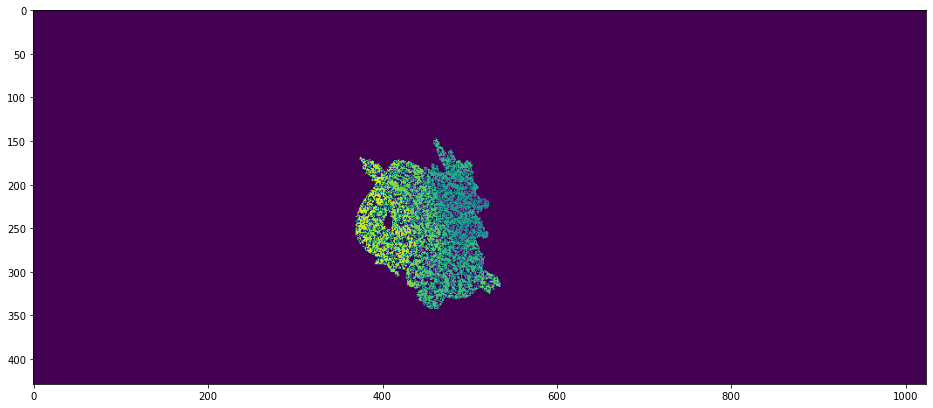

In [7]:
valid = sign_dist_nn(start, norm, travel) < 0.1
image = travel.copy()

image += image[valid].max() - 2.0 * image[valid].min()
image *= valid

plt.figure(figsize=(16,16))
plt.imshow(image)

## Linear Interpolation

The above render glitched because it jumps betwen the values in the sdf function; the problem is fixed by interpolating betwen the values. We can solve this with linear interpolation.
In 1D linear interpolation is
```
base = int(x)
t = x - base
value = (1-t) * sdf[base] + t * sdf[int(x)+1]
```
In three dimensions it is called trilinear interpolation, and can be coded as
```
base_x = int(x)
base_y = int(y)
base_z = int(z)
tx = x - base_x
ty = y - base_y
tz = z - base_z

value = 0
for oz in range(2):
  for oy in range(2):
    for ox in range(2):
      weight = 1.0
      if oz==0: weight *= 1 - tz 
      else: weight *= tz
      if oy==0: weight *= 1 - ty
      else: weight *= ty
      if ox==0: weight *= 1 - tx
      else: weight *= tx
      value += weight * sdf[base_z+oz, base_y+oy, base_x+ox]
```

 We can rewrite the sdf evaluation function that includes interpolation



In [8]:
def sign_dist_linear(start, norm, travel):
    """Given three arrays this returns how far each ray is from the closest point
    on the surface (allowed to be an underestimate if outside the sdf volume).
    Input (pos = (height, width, 3) array of starting positions,
    norm = (height, width, 3) array of directions of travel,
    travel = (height, width) array of how far each ray has travelled.);
    Output = (height, width) array of how far the end of each ray is from the surface, signed."""

    pos = start + travel[:,:,None] * norm

    
    #create uninterpolated model
    for i in range(3):
        pos[:,:,i][pos[:,:,i]>=(sdf.shape[i]-1)] = sdf.shape[i] - 2
        pos[pos[:,:,i]<0] = 0
    
    #defining base
    base_x= pos[:,:,0].astype(int)
    base_y= pos[:,:,1].astype(int)
    base_z= pos[:,:,2].astype(int)
    
    
    #defining remainder
    tx = pos[:,:,0]-base_x
    ty = pos[:,:,1]-base_y
    tz = pos[:,:,2]-base_z
    #interpolation
    value = numpy.zeros(pos.shape[:2])
    for oz in range(2):
        for oy in range(2):
            for ox in range(2):
                weight = 1.0
                if oz==0: weight *= 1 - tz 
                else: weight *= numpy.clip(tz,0,1)
                if oy==0: weight *= 1 - ty
                else: weight *= numpy.clip(ty,0,1)
                if ox==0: weight *= 1 - tx
                else: weight *= numpy.clip(tx,0,1)
                value += weight * sdf[base_x+ox, base_y+oy, base_z+oz]
    return value
    

better_travel = numpy.zeros((height, width))
for _ in range(max(sdf.shape)):
    better_travel += sign_dist_linear(start, norm, better_travel)
    better_travel[better_travel>1e6] = 1e6 # Safety

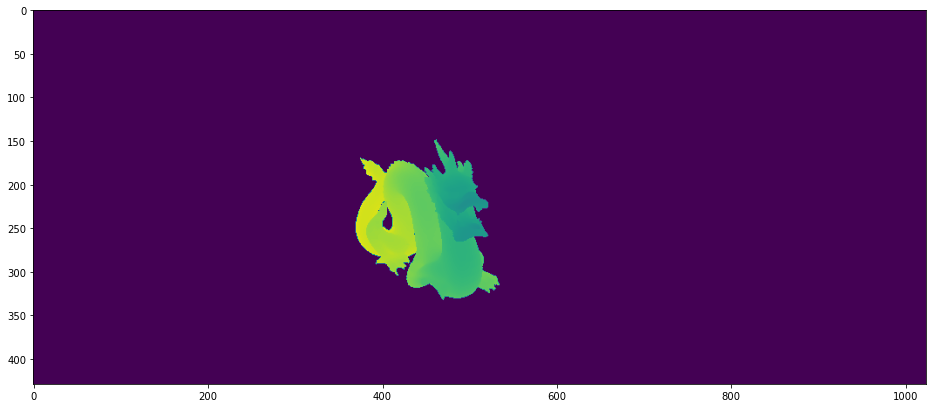

In [9]:
valid = sign_dist_linear(start, norm, better_travel) < 0.1
image = better_travel.copy()
image += image[valid].max() - 2.0 * image[valid].min()
image *= valid

plt.figure(figsize=(16,16))
plt.imshow(image)